In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# Al principio del script, después de los imports
import os
from pathlib import Path

In [2]:
import pandas as pd

# Leer el archivo CSV
# Nota: Uso sep=';' porque veo que las columnas están separadas por punto y coma
df = pd.read_csv(r"C:\Users\Usuario\Documents\Github\Seguridad económica\src\data\processed\Dependencias consolidadas\dependencias.csv\dependencias.csv", sep=';')

# Definir las columnas a revisar
columnas_check = ['dependency_value', 'direct_dependency', 'indirect_dependency', 'trade_value']

# Eliminar las filas donde todas las columnas especificadas son 0
df_limpio = df[~(df[columnas_check] == 0).all(axis=1)]

# Guardar el resultado en un nuevo archivo
# Lo guardamos en la misma ubicación pero con un nombre diferente
ruta_salida = r"C:\Users\Usuario\Documents\Github\Seguridad económica\src\data\processed\Dependencias consolidadas\dependencias_limpio.csv"
df_limpio.to_csv(ruta_salida, sep=';', index=False)

# Imprimir información sobre el proceso
print(f"Registros originales: {len(df)}")
print(f"Registros después de eliminar filas con ceros: {len(df_limpio)}")
print(f"Se eliminaron {len(df) - len(df_limpio)} registros")

Registros originales: 738520
Registros después de eliminar filas con ceros: 76747
Se eliminaron 661773 registros


In [44]:
df = df_limpio.copy()


# Configuración de estilo general
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['axes.grid'] = True
plt.rcParams['font.size'] = 10


# Países de interés
countries = {
    'CAN': 'Canadá',
    'MEX': 'México',
    'DEU': 'Alemania',
    'FRA': 'Francia',
    'ITA': 'Italia',
    'ESP': 'España',
    'GBR': 'Reino Unido'
}

# Filtrar datos para USA como proveedor y los países de interés
usa_deps = df[
    (df['supplier_country'] == 'USA') & 
    (df['dependent_country'].isin(countries.keys()))
].copy()

# Reemplazar códigos de país por nombres
usa_deps['dependent_country'] = usa_deps['dependent_country'].map(countries)

# Figura 1: Dependencia Total vs Componentes (con media ponderada)
def plot_weighted_dependency_components():
    # Calcular medias ponderadas por país
    deps_by_country = []
    
    for country in countries.values():
        country_data = usa_deps[usa_deps['dependent_country'] == country]
        
        # Calcular medias ponderadas
        weighted_total = np.average(
            country_data['dependency_value'],
            weights=country_data['trade_value']
        )
        weighted_direct = np.average(
            country_data['direct_dependency'],
            weights=country_data['trade_value']
        )
        weighted_indirect = np.average(
            country_data['indirect_dependency'],
            weights=country_data['trade_value']
        )
        
        deps_by_country.append({
            'dependent_country': country,
            'dependency_value': weighted_total,
            'direct_dependency': weighted_direct,
            'indirect_dependency': weighted_indirect
        })
    
    deps_by_country = pd.DataFrame(deps_by_country)
    
    # Ordenar por dependencia total
    deps_by_country = deps_by_country.sort_values('dependency_value', ascending=False)
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    x = np.arange(len(deps_by_country['dependent_country']))
    width = 0.35
    
    # Crear barras apiladas
    p1 = ax.bar(x, deps_by_country['direct_dependency'], width,
                label='Dependencia Directa', color='#4C51BF')
    p2 = ax.bar(x, deps_by_country['indirect_dependency'], width,
                bottom=deps_by_country['direct_dependency'],
                label='Dependencia Indirecta', color='#9FA8DA')
    
    # Añadir línea de dependencia total
    ax.plot(x, deps_by_country['dependency_value'], 'ro-', linewidth=2,
            label='Dependencia Total')
    
    # Personalizar gráfico
    ax.set_xticks(x)
    ax.set_xticklabels(deps_by_country['dependent_country'], rotation=45, ha='right')
    ax.set_ylabel('Nivel de Dependencia')
    ax.set_title('Dependencia con Estados Unidos: Total y Componentes\n(Media Ponderada por Valor Comercial)')
    ax.legend()
    
    # Añadir valores en las barras
    for i in x:
        total = deps_by_country.iloc[i]['dependency_value']
        ax.text(i, total + 0.02, f'{total:.2%}', ha='center')
    
    plt.tight_layout()
    return fig, deps_by_country

# Figura 2: Número de Industrias Dependientes
def plot_industries_count():
    industry_counts = usa_deps.groupby('dependent_country').size().reset_index()
    industry_counts.columns = ['País', 'Número de Industrias']
    industry_counts = industry_counts.sort_values('Número de Industrias', ascending=False)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(industry_counts['País'], industry_counts['Número de Industrias'], 
                 color='#3B82F6')
    
    # Añadir etiquetas de valor sobre las barras
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom')
    
    plt.xticks(rotation=45, ha='right')
    plt.title('Número de Industrias con Dependencia de Estados Unidos')
    plt.ylabel('Número de Industrias')
    plt.tight_layout()
    
    return fig

# Figura 3: Top Industrias por País (considerando valor comercial)
def plot_top_industries():
    plt.style.use('default')
    
    # Cambiar a 4x2 para acomodar los 7 países
    fig, axes = plt.subplots(4, 2, figsize=(20, 16))  # Aumentar altura
    plt.subplots_adjust(right=0.85)
    axes = axes.ravel()
    
    selected_countries = list(countries.values())  # Usar todos los países
    
    for idx, country in enumerate(selected_countries):
        country_data = usa_deps[usa_deps['dependent_country'] == country].copy()
        
        top_industries = country_data.nlargest(5, 'dependency_value')
        
        bars = axes[idx].barh(top_industries['industry'], 
                            top_industries['dependency_value'],
                            color='#3B82F6')
        
        # Eliminar grid y ajustar spines
        axes[idx].grid(False)
        for spine in axes[idx].spines.values():
            spine.set_visible(False)
        axes[idx].spines['left'].set_visible(True)
        
        # Ajustar etiquetas
        for bar, trade_val in zip(bars, top_industries['trade_value']):
            width = bar.get_width()
            axes[idx].text(width, bar.get_y() + bar.get_height()/2.,
                          f'{width:.2%}',
                          ha='left', va='center', fontsize=8)
        
        axes[idx].set_title(f'Top 5 Industrias - {country}')
        axes[idx].set_xlabel('Nivel de Dependencia')
        axes[idx].set_xlim(0, 1.2)  # Dar espacio para las etiquetas
    
    # Eliminar el último subplot que queda vacío
    fig.delaxes(axes[-1])
    
    plt.tight_layout()
    return fig

# Generar estadísticas descriptivas
def print_weighted_statistics():
    print("\nEstadísticas de dependencia por país (ponderadas por valor comercial):")
    
    stats = []
    for country in countries.values():
        country_data = usa_deps[usa_deps['dependent_country'] == country]
        
        weighted_stats = {
            'País': country,
            'Media Ponderada Total': np.average(
                country_data['dependency_value'],
                weights=country_data['trade_value']
            ),
            'Media Ponderada Directa': np.average(
                country_data['direct_dependency'],
                weights=country_data['trade_value']
            ),
            'Media Ponderada Indirecta': np.average(
                country_data['indirect_dependency'],
                weights=country_data['trade_value']
            ),
            'Valor Comercial Total (M$)': country_data['trade_value'].sum()
        }
        stats.append(weighted_stats)
    
    stats_df = pd.DataFrame(stats)
    print(stats_df.round(3))
    
    # Top 3 industrias más dependientes por país (considerando valor comercial)
    for country in countries.values():
        print(f"\nTop 3 industrias más dependientes - {country}:")
        country_data = usa_deps[usa_deps['dependent_country'] == country]
        top3 = country_data.nlargest(3, 'dependency_value')[
            ['industry', 'dependency_value', 'trade_value']
        ].round(3)
        print(top3)

# Ejecutar análisis
print_weighted_statistics()

# Guardar gráficos

# Al final del script, reemplazar la parte de guardar las figuras con:
try:
    # Configurar directorio de salida
    current_dir = Path.cwd()
    image_dir = current_dir.parent / 'docs' / 'RIelcano_USA' / 'images'
    image_dir.mkdir(parents=True, exist_ok=True)
    
    # Generar y guardar las figuras
    fig1, deps_data = plot_weighted_dependency_components()
    fig1.savefig(image_dir / 'usa_weighted_dependency_components.png', dpi=300, bbox_inches='tight')
    
    fig2 = plot_industries_count()
    fig2.savefig(image_dir / 'usa_industries_count.png', dpi=300, bbox_inches='tight')
    
    fig3 = plot_top_industries()
    fig3.savefig(image_dir / 'usa_top_industries_weighted.png', dpi=300, bbox_inches='tight')
    
    print(f"Imágenes guardadas en: {image_dir}")
    
except Exception as e:
    print(f"Error al guardar las imágenes: {str(e)}")
finally:
    plt.close('all')


Estadísticas de dependencia por país (ponderadas por valor comercial):
          País  Media Ponderada Total  Media Ponderada Directa  \
0       Canadá                  0.679                    0.642   
1       México                  0.493                    0.470   
2     Alemania                  0.218                    0.133   
3      Francia                  0.243                    0.130   
4       Italia                  0.229                    0.120   
5       España                  0.280                    0.182   
6  Reino Unido                  0.376                    0.295   

   Media Ponderada Indirecta  Valor Comercial Total (M$)  
0                      0.037                  285998.955  
1                      0.023                  219141.404  
2                      0.084                  107882.743  
3                      0.113                   48356.375  
4                      0.110                   17608.230  
5                      0.098                 

In [39]:
image_dir

WindowsPath('c:/Users/Usuario/Documents/Github/Seguridad económica/src/docs/RIelcano_USA/images')

In [26]:
# Configuración de estilo
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['axes.grid'] = True
plt.rcParams['font.size'] = 10

# Usar el dataframe ya preparado
df = df_limpio.copy()

# Definir grupos de industrias estratégicas
strategic_sectors = {
    'Vehículo Eléctrico y Automóvil': [
        'Motor vehicles',
        'Parts/accessories for automobiles',
        'Automobile bodies trailers & semi-trailers',
        'Electric motors generators and transformers',
        'Electricity distribution & control apparatus',
        'Accumulators primary cells and batteries',
        'Other electrical equipment n.e.c.'
    ],
    
    'Semiconductores y Electrónica': [
        'Electronic valves tubes etc.',
        'Office accounting and computing machinery',
        'TV/radio transmitters; line comm. apparatus',
        'TV and radio receivers and associated goods',
        'Measuring/testing/navigating appliances etc.',
        'Telecommunications, computer, and information services',
        'Insulated wire and cable'
    ],
    
    'Defensa y Aeroespacial': [
        'Aircraft and spacecraft',
        'Building and repairing of ships',
        'Weapons and ammunition',
        'Optical instruments & photographic equipment',
        'Measuring/testing/navigating appliances etc.',
        'Other transport equipment n.e.c.'
    ]
}

# Países de interés
countries = {
    'CAN': 'Canadá',
    'MEX': 'México',
    'DEU': 'Alemania',
    'FRA': 'Francia',
    'ITA': 'Italia',
    'ESP': 'España',
    'GBR': 'Reino Unido'
}

def analyze_strategic_sector(df, sector_name, sector_industries):
    """Analiza un sector estratégico específico."""
    # Filtrar datos para el sector
    sector_data = df[
        (df['supplier_country'] == 'USA') & 
        (df['dependent_country'].isin(countries.keys())) &
        (df['industry'].isin(sector_industries))
    ].copy()
    
    # Primero, veamos qué industrias tenemos datos
    print(f"\nIndustrias encontradas en {sector_name}:")
    print(sector_data['industry'].unique())
    
    # Calcular dependencias ponderadas por país
    country_deps = []
    for country_code, country_name in countries.items():
        country_data = sector_data[sector_data['dependent_country'] == country_code]
        
        if len(country_data) > 0:
            # Verificar si hay valores comerciales válidos
            valid_trades = country_data['trade_value'] > 0
            if valid_trades.any():
                # Usar solo datos con trade_value > 0
                valid_data = country_data[valid_trades]
                
                weighted_total = np.average(
                    valid_data['dependency_value'],
                    weights=valid_data['trade_value']
                )
                weighted_direct = np.average(
                    valid_data['direct_dependency'],
                    weights=valid_data['trade_value']
                )
                weighted_indirect = np.average(
                    valid_data['indirect_dependency'],
                    weights=valid_data['trade_value']
                )
                total_trade = valid_data['trade_value'].sum()
                
                # Añadir información sobre industrias encontradas
                industries_found = valid_data['industry'].unique()
                missing_industries = set(sector_industries) - set(industries_found)
                
                country_deps.append({
                    'País': country_name,
                    'Dependencia Total': weighted_total,
                    'Dependencia Directa': weighted_direct,
                    'Dependencia Indirecta': weighted_indirect,
                    'Valor Comercial': total_trade,
                    'Industrias Encontradas': len(industries_found),
                    'Industrias Sin Datos': len(missing_industries)
                })
            else:
                print(f"Advertencia: No hay valores comerciales válidos para {country_name}")
                country_deps.append({
                    'País': country_name,
                    'Dependencia Total': 0,
                    'Dependencia Directa': 0,
                    'Dependencia Indirecta': 0,
                    'Valor Comercial': 0,
                    'Industrias Encontradas': 0,
                    'Industrias Sin Datos': len(sector_industries)
                })
        else:
            print(f"Advertencia: No hay datos para {country_name}")
            country_deps.append({
                'País': country_name,
                'Dependencia Total': 0,
                'Dependencia Directa': 0,
                'Dependencia Indirecta': 0,
                'Valor Comercial': 0,
                'Industrias Encontradas': 0,
                'Industrias Sin Datos': len(sector_industries)
            })
    
    return pd.DataFrame(country_deps)

def plot_strategic_sector(sector_data, sector_name):
    """Crea visualización para un sector estratégico."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Ordenar por dependencia total
    sector_data_sorted = sector_data.sort_values('Dependencia Total', ascending=True)
    
    # Gráfico de barras horizontales para dependencias
    bars1 = ax1.barh(sector_data_sorted['País'], 
                    sector_data_sorted['Dependencia Directa'],
                    label='Directa', color='#4C51BF')
    bars2 = ax1.barh(sector_data_sorted['País'], 
                     sector_data_sorted['Dependencia Indirecta'],
                     left=sector_data_sorted['Dependencia Directa'],
                     label='Indirecta', color='#9FA8DA')
    
    # Añadir etiquetas de valor total
    for i, country in enumerate(sector_data_sorted['País']):
        total = sector_data_sorted.iloc[i]['Dependencia Total']
        if total > 0:  # Solo añadir etiqueta si hay dependencia
            ax1.text(total + 0.02, i, f'{total:.1%}', va='center')
    
    ax1.set_title(f'Dependencias en Sector {sector_name}')
    ax1.legend()
    ax1.set_xlabel('Nivel de Dependencia')
    
    # Gráfico de barras para valor comercial
    bars3 = ax2.barh(sector_data_sorted['País'], 
                     sector_data_sorted['Valor Comercial'],
                     color='#3B82F6')
    
    # Añadir etiquetas de valor comercial
    for bar in bars3:
        width = bar.get_width()
        if width > 0:  # Solo añadir etiqueta si hay valor comercial
            ax2.text(width, bar.get_y() + bar.get_height()/2.,
                     f'${width:.1f}M', va='center')
    
    ax2.set_title(f'Valor Comercial en Sector {sector_name}')
    ax2.set_xlabel('Millones de USD')
    
    plt.tight_layout()
    return fig

def analyze_all_strategic_sectors():
    """Analiza todos los sectores estratégicos."""
    # Configurar directorio de salida
    current_dir = Path.cwd()
    image_dir = current_dir.parent / 'docs' / 'RIelcano_USA' / 'images'
    image_dir.mkdir(parents=True, exist_ok=True)
    
    results = {}
    for sector_name, industries in strategic_sectors.items():
        print(f"\nAnálisis del sector: {sector_name}")
        print(f"Buscando las siguientes industrias: {industries}")
        
        # Analizar sector
        sector_data = analyze_strategic_sector(df, sector_name, industries)
        results[sector_name] = sector_data
        
        # Mostrar estadísticas
        print("\nEstadísticas ponderadas por valor comercial:")
        print(sector_data.round(3))
        
        # Mostrar información sobre industrias faltantes
        print("\nResumen de datos encontrados:")
        for _, row in sector_data.iterrows():
            print(f"{row['País']}: {row['Industrias Encontradas']} industrias con datos, "
                  f"{row['Industrias Sin Datos']} sin datos")
        
        # Crear y guardar visualización
        fig = plot_strategic_sector(sector_data, sector_name)
        fig.savefig(
            image_dir / f'usa_dependency_{sector_name.lower().replace(" ", "_")}.png',
            dpi=300,
            bbox_inches='tight'
        )
        plt.close(fig)
    
    return results

# Ejecutar el análisis completo
try:
    results = analyze_all_strategic_sectors()
except Exception as e:
    print(f"Error en el análisis: {str(e)}")
finally:
    plt.close('all')


Análisis del sector: Vehículo Eléctrico y Automóvil
Buscando las siguientes industrias: ['Motor vehicles', 'Parts/accessories for automobiles', 'Automobile bodies trailers & semi-trailers', 'Electric motors generators and transformers', 'Electricity distribution & control apparatus', 'Accumulators primary cells and batteries', 'Other electrical equipment n.e.c.']

Industrias encontradas en Vehículo Eléctrico y Automóvil:
['Accumulators primary cells and batteries'
 'Automobile bodies trailers & semi-trailers'
 'Electric motors generators and transformers'
 'Electricity distribution & control apparatus' 'Motor vehicles'
 'Other electrical equipment n.e.c.' 'Parts/accessories for automobiles']
Advertencia: No hay valores comerciales válidos para Italia
Advertencia: No hay valores comerciales válidos para España

Estadísticas ponderadas por valor comercial:
          País  Dependencia Total  Dependencia Directa  Dependencia Indirecta  \
0       Canadá              0.656                0.

In [ ]:
import seaborn as sns
def plot_sector_comparison(results):
    """
    Crea un gráfico comparativo de todos los sectores estratégicos.
    """
    # Preparar datos para la comparación
    comparison_data = []
    for sector_name, sector_df in results.items():
        for _, row in sector_df.iterrows():
            comparison_data.append({
                'Sector': sector_name,
                'País': row['País'],
                'Dependencia Total': row['Dependencia Total'],
                'Valor Comercial': row['Valor Comercial']
            })
    
    comparison_df = pd.DataFrame(comparison_data)
    
    # Crear gráfico
    fig, ax = plt.subplots(figsize=(15, 8))
    
    # Crear heatmap de dependencias
    pivot_data = comparison_df.pivot(
        index='País', 
        columns='Sector', 
        values='Dependencia Total'
    )
    
    sns.heatmap(pivot_data, 
                annot=True, 
                fmt='.1%',
                cmap='YlOrRd',
                cbar_kws={'label': 'Nivel de Dependencia'},
                ax=ax)
    
    plt.title('Comparación de Dependencias por Sector y País')
    plt.tight_layout()
    
    return fig

def plot_industry_details(df, sector_name, sector_industries):
    """
    Crea un gráfico detallado de las industrias dentro de un sector.
    """
    # Filtrar datos
    sector_data = df[
        (df['supplier_country'] == 'USA') & 
        (df['industry'].isin(sector_industries))
    ].copy()
    
    # Calcular promedios ponderados por industria
    industry_stats = []
    for industry in sector_industries:
        ind_data = sector_data[sector_data['industry'] == industry]
        if len(ind_data) > 0:
            weighted_total = np.average(
                ind_data['dependency_value'],
                weights=ind_data['trade_value']
            )
            total_trade = ind_data['trade_value'].sum()
            
            industry_stats.append({
                'Industria': industry,
                'Dependencia Media': weighted_total,
                'Valor Comercial': total_trade
            })
    
    industry_df = pd.DataFrame(industry_stats)
    
    # Crear visualización
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
    
    # Gráfico de dependencias por industria
    industry_df_sorted = industry_df.sort_values('Dependencia Media', ascending=True)
    bars1 = ax1.barh(industry_df_sorted['Industria'], 
                     industry_df_sorted['Dependencia Media'])
    
    # Añadir etiquetas
    for bar in bars1:
        width = bar.get_width()
        ax1.text(width, bar.get_y() + bar.get_height()/2.,
                 f'{width:.1%}', va='center')
    
    ax1.set_title(f'Dependencia Media por Industria en {sector_name}')
    ax1.set_xlabel('Nivel de Dependencia')
    
    # Gráfico de valor comercial por industria
    industry_df_sorted = industry_df.sort_values('Valor Comercial', ascending=True)
    bars2 = ax2.barh(industry_df_sorted['Industria'], 
                     industry_df_sorted['Valor Comercial'])
    
    # Añadir etiquetas
    for bar in bars2:
        width = bar.get_width()
        ax2.text(width, bar.get_y() + bar.get_height()/2.,
                 f'${width:.1f}M', va='center')
    
    ax2.set_title(f'Valor Comercial por Industria en {sector_name}')
    ax2.set_xlabel('Millones de USD')
    
    plt.tight_layout()
    return fig

def plot_dependency_network(df, sector_name, sector_industries):
    """
    Crea un gráfico que muestra la red de dependencias directas vs indirectas.
    """
    # Filtrar datos
    sector_data = df[
        (df['supplier_country'] == 'USA') & 
        (df['dependent_country'].isin(countries.keys())) &
        (df['industry'].isin(sector_industries))
    ].copy()
    
    # Calcular promedios por país
    country_stats = []
    for country_code, country_name in countries.items():
        country_data = sector_data[sector_data['dependent_country'] == country_code]
        if len(country_data) > 0:
            weighted_direct = np.average(
                country_data['direct_dependency'],
                weights=country_data['trade_value']
            )
            weighted_indirect = np.average(
                country_data['indirect_dependency'],
                weights=country_data['trade_value']
            )
            total_trade = country_data['trade_value'].sum()
            
            country_stats.append({
                'País': country_name,
                'Dependencia Directa': weighted_direct,
                'Dependencia Indirecta': weighted_indirect,
                'Valor Comercial': total_trade
            })
    
    country_df = pd.DataFrame(country_stats)
    
    # Crear visualización
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Scatter plot con tamaño variable según valor comercial
    scatter = ax.scatter(country_df['Dependencia Directa'], 
                        country_df['Dependencia Indirecta'],
                        s=country_df['Valor Comercial']/100,  # Ajustar tamaño
                        alpha=0.6)
    
    # Añadir etiquetas para cada punto
    for idx, row in country_df.iterrows():
        ax.annotate(row['País'], 
                   (row['Dependencia Directa'], row['Dependencia Indirecta']),
                   xytext=(5, 5), textcoords='offset points')
    
    # Añadir línea diagonal de referencia
    ax.plot([0, max(ax.get_xlim()[1], ax.get_ylim()[1])], 
            [0, max(ax.get_xlim()[1], ax.get_ylim()[1])],
            'k--', alpha=0.3)
    
    ax.set_xlabel('Dependencia Directa')
    ax.set_ylabel('Dependencia Indirecta')
    ax.set_title(f'Relación entre Dependencias Directas e Indirectas\n{sector_name}')
    
    # Formato de porcentaje en los ejes
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.1%}'))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.1%}'))
    
    plt.tight_layout()
    return fig

# Función para generar todas las visualizaciones adicionales
def create_additional_visualizations(df, results):
    # Configurar directorio de salida
    current_dir = Path.cwd()
    image_dir = current_dir.parent / 'docs' / 'RIelcano_USA' / 'images'
    image_dir.mkdir(parents=True, exist_ok=True)
    
    # 1. Comparación entre sectores
    fig_comparison = plot_sector_comparison(results)
    fig_comparison.savefig(
        image_dir / 'usa_sector_comparison.png',
        dpi=300,
        bbox_inches='tight'
    )
    
    # 2. Detalles por industria para cada sector
    for sector_name, industries in strategic_sectors.items():
        fig_details = plot_industry_details(df, sector_name, industries)
        fig_details.savefig(
            image_dir / f'usa_industry_details_{sector_name.lower().replace(" ", "_")}.png',
            dpi=300,
            bbox_inches='tight'
        )
        
        # 3. Red de dependencias
        fig_network = plot_dependency_network(df, sector_name, industries)
        fig_network.savefig(
            image_dir / f'usa_dependency_network_{sector_name.lower().replace(" ", "_")}.png',
            dpi=300,
            bbox_inches='tight'
        )
        
        plt.close('all')

# Para usar estas visualizaciones:
create_additional_visualizations(df, results)

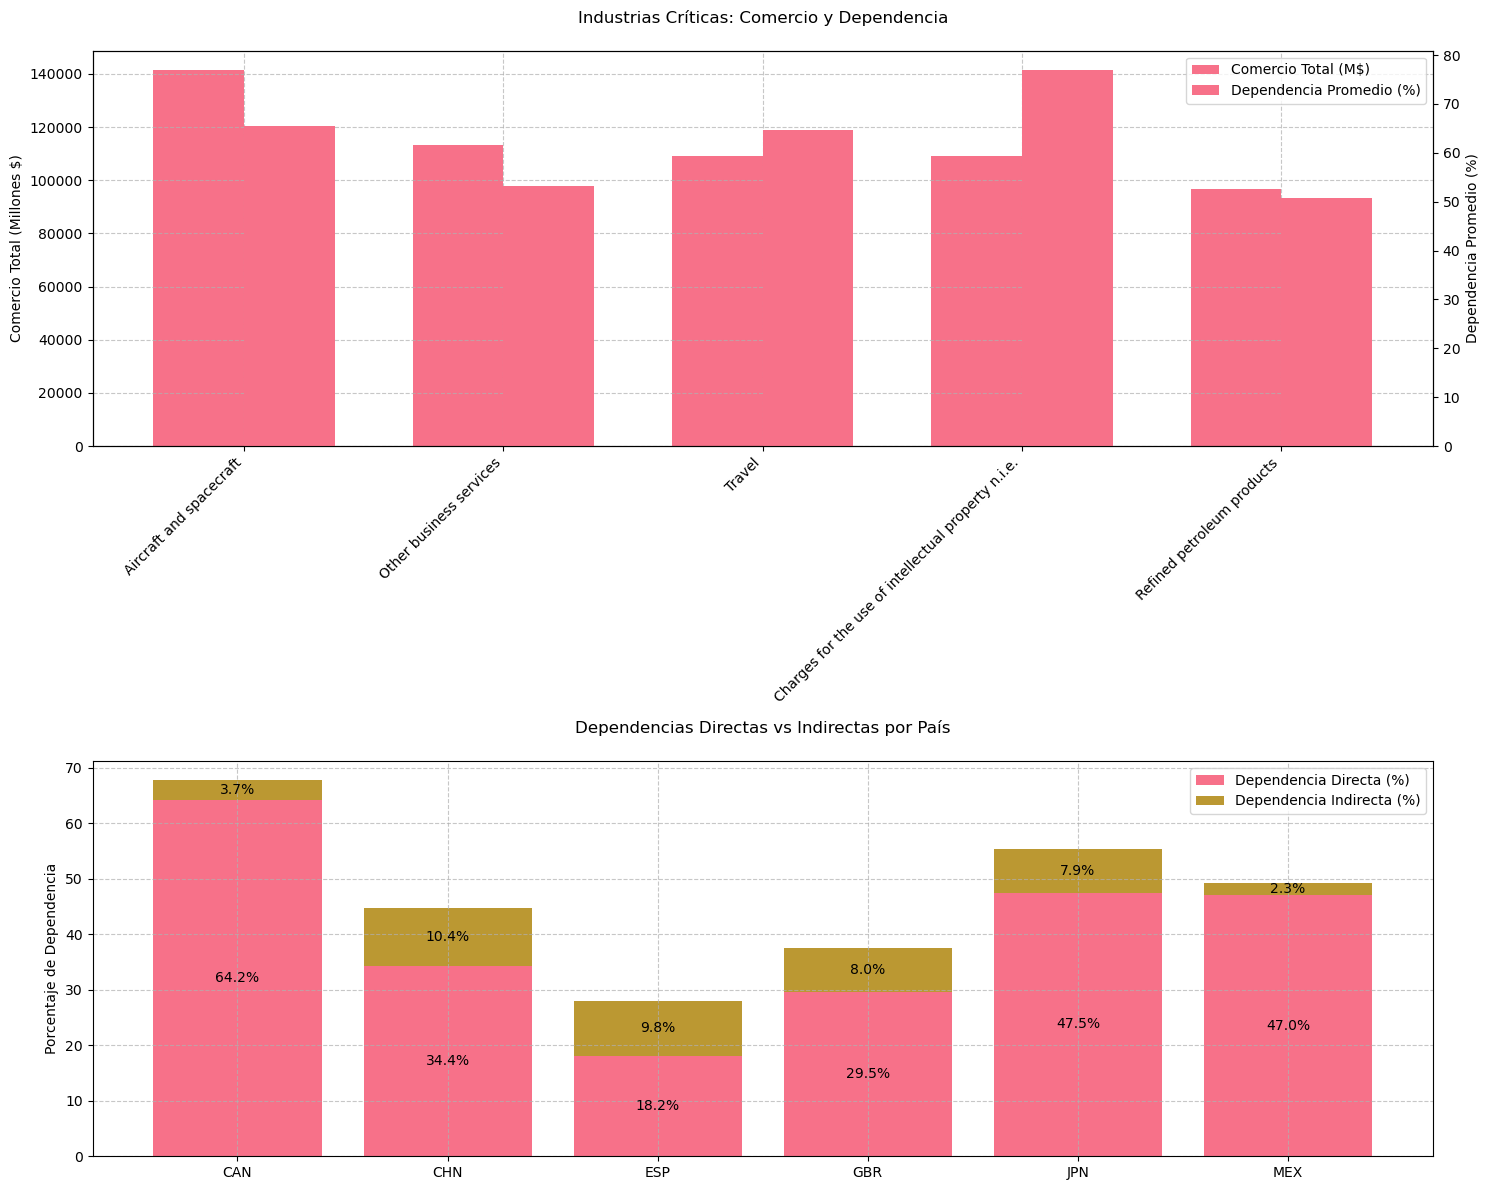


Industrias Críticas:
                                              industry    trade_value  \
2                              Aircraft and spacecraft  141643.443059   
83                             Other business services  113227.000000   
148                                             Travel  109240.000000   
19   Charges for the use of intellectual property n...  109179.000000   
123                         Refined petroleum products   96625.813778   

     dependency_value  dependent_country  
2            0.655443                 40  
83           0.532370                  8  
148          0.646122                 20  
19           0.770399                 37  
123          0.507046                 48  

Dependencias por País:
  dependent_country    trade_value  direct_dependency  indirect_dependency
0               CAN  285998.955024           0.641582             0.036970
1               CHN  171114.228129           0.343742             0.103900
2               ESP   15004.5259

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Leer el CSV
df = df_limpio

# 1. Preparar datos para el primer gráfico - Industrias críticas
industrias_criticas = df[df['supplier_country'] == 'USA'].groupby('industry').agg({
    'trade_value': 'sum',
    'dependency_value': lambda x: np.average(x, weights=df.loc[x.index, 'trade_value']),
    'dependent_country': 'nunique'
}).reset_index()

# Filtrar industrias críticas
industrias_criticas = industrias_criticas[
    (industrias_criticas['dependency_value'] > 0.5) & 
    (industrias_criticas['trade_value'] > 50000)
].sort_values('trade_value', ascending=False).head(5)

# 2. Preparar datos para el segundo gráfico - Dependencias por país
paises_interes = ['CAN', 'MEX', 'CHN', 'JPN', 'GBR', 'ESP']
dependencias_pais = df[
    (df['supplier_country'] == 'USA') & 
    (df['dependent_country'].isin(paises_interes))
].groupby('dependent_country').agg({
    'trade_value': 'sum',
    'direct_dependency': lambda x: np.average(x, weights=df.loc[x.index, 'trade_value']),
    'indirect_dependency': lambda x: np.average(x, weights=df.loc[x.index, 'trade_value'])
}).reset_index()

# Configuración del estilo
plt.style.use('default')  # Usando el estilo default de matplotlib
sns.set_palette("husl")   # Usando una paleta de colores de seaborn

# Crear los gráficos
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# 1. Gráfico de industrias críticas
x = range(len(industrias_criticas))
width = 0.35

# Añadir cuadrícula
ax1.grid(True, linestyle='--', alpha=0.7)

bars1 = ax1.bar([i - width/2 for i in x], industrias_criticas['trade_value'], 
                width, label='Comercio Total (M$)')
ax2_twin = ax1.twinx()
bars2 = ax2_twin.bar([i + width/2 for i in x], industrias_criticas['dependency_value'] * 100, 
                     width, label='Dependencia Promedio (%)')

# Configuración del primer gráfico
ax1.set_ylabel('Comercio Total (Millones $)', fontsize=10)
ax2_twin.set_ylabel('Dependencia Promedio (%)', fontsize=10)
ax1.set_title('Industrias Críticas: Comercio y Dependencia', fontsize=12, pad=20)
ax1.set_xticks(x)
ax1.set_xticklabels(industrias_criticas['industry'], rotation=45, ha='right')

# Añadir leyendas
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2_twin.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

# 2. Gráfico de dependencias por país
ax2.grid(True, linestyle='--', alpha=0.7)

bottom_bars = ax2.bar(dependencias_pais['dependent_country'], 
                     dependencias_pais['direct_dependency'] * 100, 
                     label='Dependencia Directa (%)')

top_bars = ax2.bar(dependencias_pais['dependent_country'], 
                   dependencias_pais['indirect_dependency'] * 100,
                   bottom=dependencias_pais['direct_dependency'] * 100, 
                   label='Dependencia Indirecta (%)')

# Configuración del segundo gráfico
ax2.set_ylabel('Porcentaje de Dependencia', fontsize=10)
ax2.set_title('Dependencias Directas vs Indirectas por País', fontsize=12, pad=20)
ax2.legend()

# Ajustar etiquetas del eje x
plt.xticks(rotation=45, ha='right')

# Añadir valores sobre las barras en el segundo gráfico
for bars in [bottom_bars, top_bars]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:  # Solo mostrar etiquetas para valores positivos
            ax2.text(bar.get_x() + bar.get_width()/2., 
                    bar.get_y() + height/2.,
                    f'{height:.1f}%',
                    ha='center', va='center')

# Ajustar layout
plt.tight_layout()

# Mostrar gráficos
plt.show()

# Imprimir las tablas de datos calculados
print("\nIndustrias Críticas:")
print(industrias_criticas)
print("\nDependencias por País:")
print(dependencias_pais)

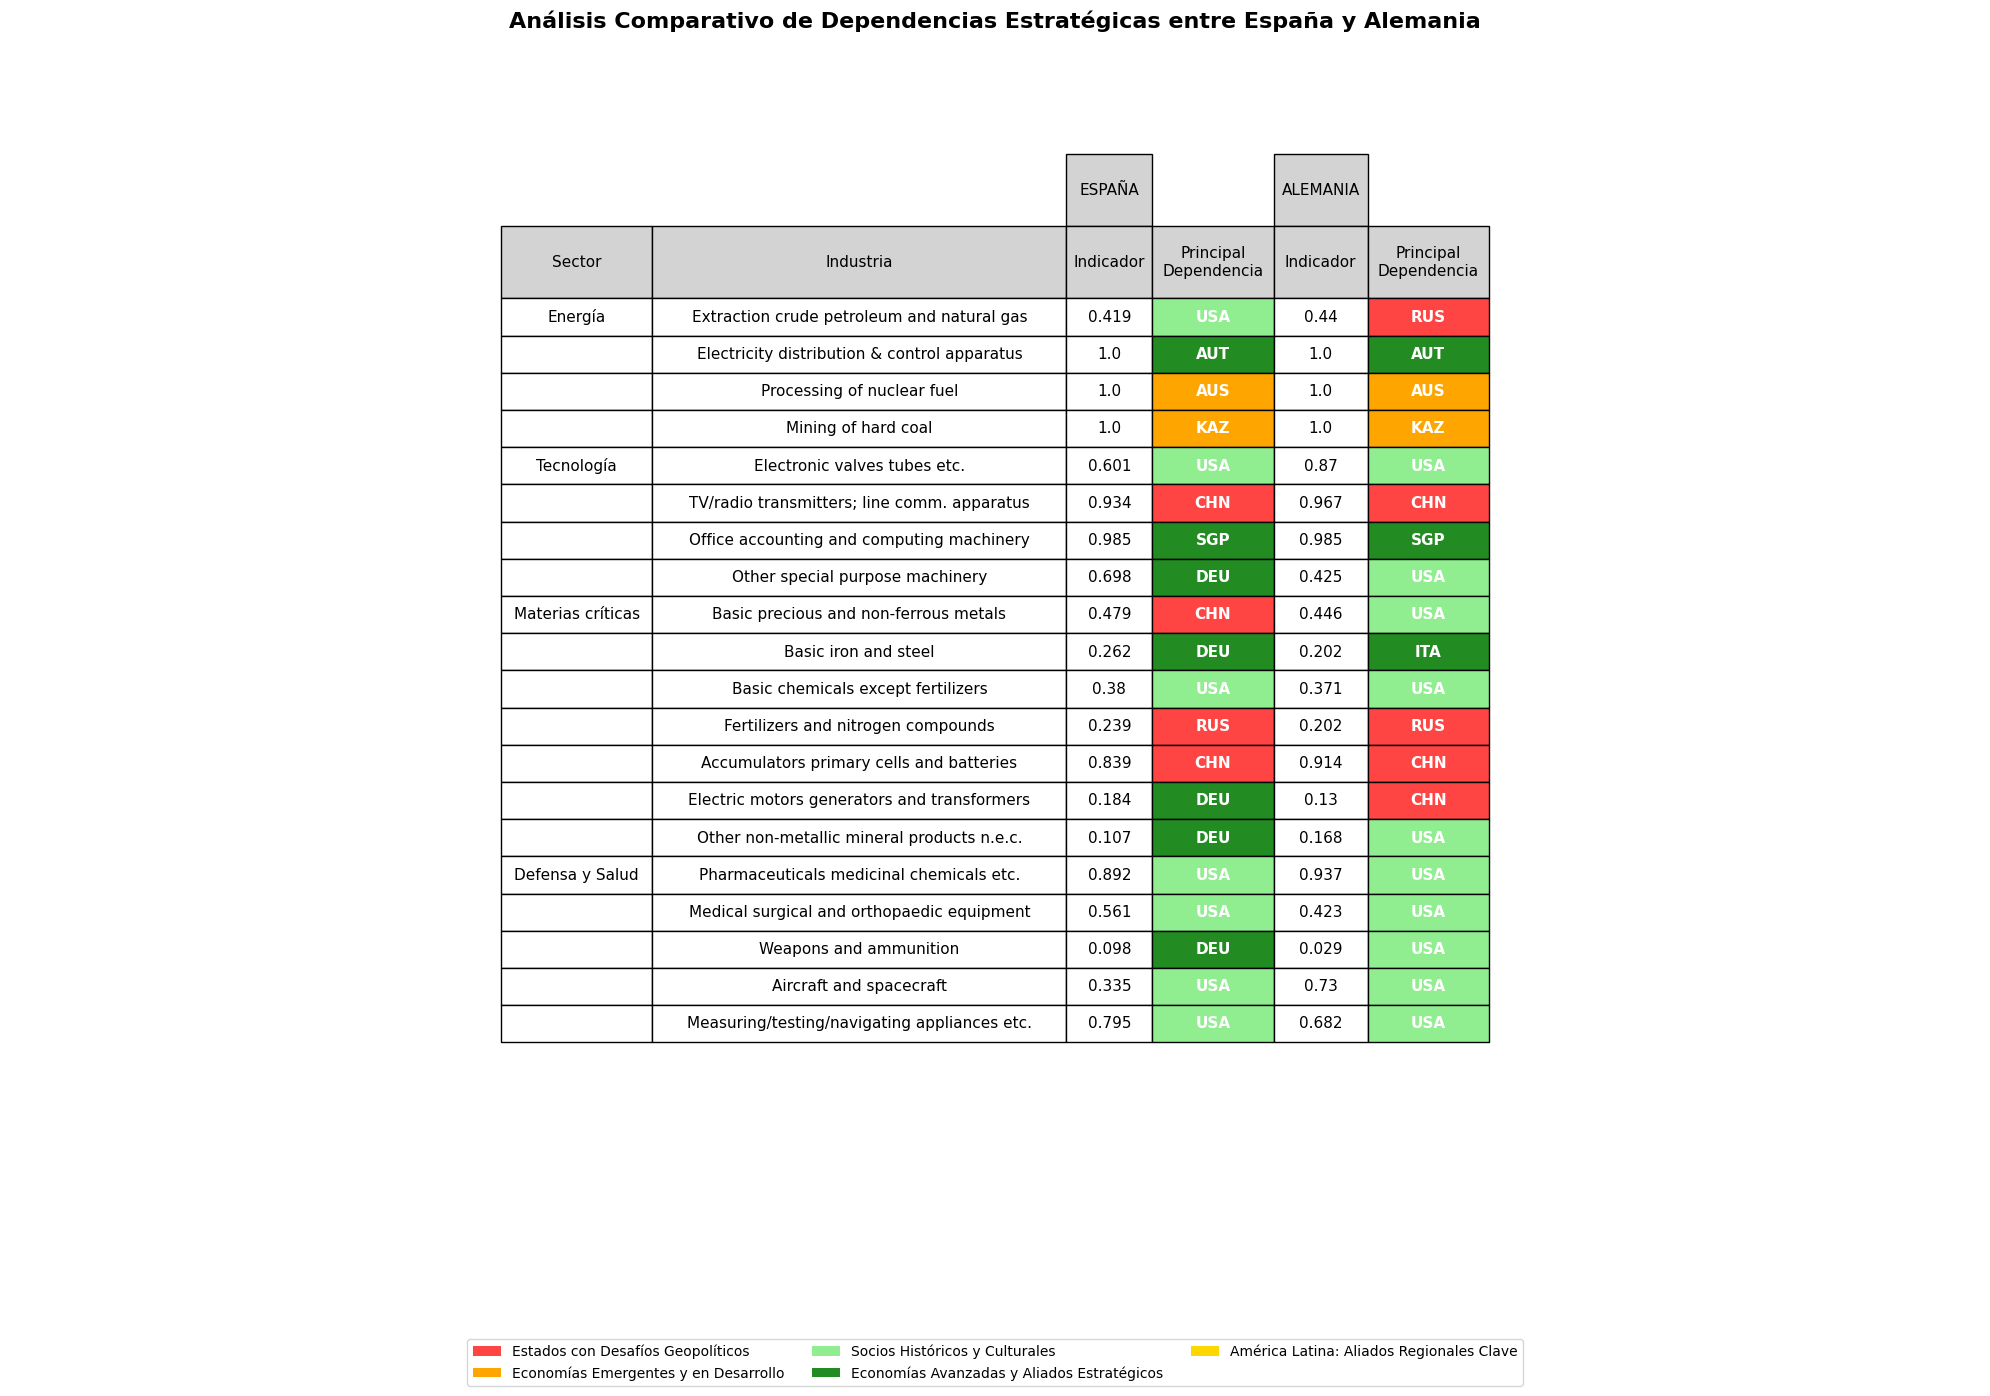

In [6]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def crear_tabla_visual(df):
   
   
   cluster_colors = {
       1: '#FF4444',  
       0: '#FFA500',  
       2: '#90EE90',  
       3: '#228B22',  
       4: '#FFD700'   
   }
   
   cluster_nombres = {
       1: 'Estados con Desafíos Geopolíticos',
       0: 'Economías Emergentes y en Desarrollo',
       2: 'Socios Históricos y Culturales',
       3: 'Economías Avanzadas y Aliados Estratégicos',
       4: 'América Latina: Aliados Regionales Clave'
   }
   
   fig, ax = plt.subplots(figsize=(20, 14))
   
   for spine in ax.spines.values():
       spine.set_visible(False)

   # Modificar Sector
   df_mod = df.copy()
   prev_sector = ""
   for idx, row in df_mod.iterrows():
       if row['Sector'] == prev_sector:
           df_mod.at[idx, 'Sector'] = ""
       else:
           prev_sector = row['Sector']

   cell_values = df_mod[['Sector', 'Industria', 'ESP_valor', 'ESP_pais', 'DEU_valor', 'DEU_pais']].values

   # Crear tabla base sin headers
   tabla = ax.table(
       cellText=cell_values,
       loc='center',
       cellLoc='center'
   )
   
   tabla.auto_set_column_width([0,1,2,3,4,5])
   tabla.set_fontsize(11)
   tabla.scale(1.5, 2)
   
   # Headers con fondo gris
   tabla.add_cell(-1, 0, width=1, height=0.06, text='Sector', 
                 loc='center', facecolor='lightgray')
   tabla.add_cell(-1, 1, width=1, height=0.06, text='Industria', 
                 loc='center', facecolor='lightgray')
   
   # España header y subheaders
   tabla.add_cell(-2, 2, width=2, height=0.06, text='ESPAÑA', 
                 loc='center', facecolor='lightgray')
   tabla.add_cell(-1, 2, width=1, height=0.06, text='Indicador', 
                 loc='center', facecolor='lightgray')
   tabla.add_cell(-1, 3, width=1, height=0.06, text='Principal\nDependencia', 
                 loc='center', facecolor='lightgray')
   
   # Alemania header y subheaders  
   tabla.add_cell(-2, 4, width=2, height=0.06, text='ALEMANIA', 
                 loc='center', facecolor='lightgray')
   tabla.add_cell(-1, 4, width=1, height=0.06, text='Indicador', 
                 loc='center', facecolor='lightgray')
   tabla.add_cell(-1, 5, width=1, height=0.06, text='Principal\nDependencia', 
                 loc='center', facecolor='lightgray')
   
   for idx, row in df.iterrows():
       tabla._cells[(idx, 3)].set_facecolor(cluster_colors[row['ESP_cluster']])
       tabla._cells[(idx, 5)].set_facecolor(cluster_colors[row['DEU_cluster']])
       tabla._cells[(idx, 3)].set_text_props(color='white', weight='bold')
       tabla._cells[(idx, 5)].set_text_props(color='white', weight='bold')

   # Leyenda
   legend_elements = [
       mpatches.Patch(facecolor=color, label=cluster_nombres[cluster_id])
       for cluster_id, color in cluster_colors.items()
   ]
   ax.legend(handles=legend_elements, 
            loc='upper center', 
            bbox_to_anchor=(0.5, -0.05),
            ncol=3,
            fontsize=10)

   ax.set_xticks([])
   ax.set_yticks([])
   
   plt.title('Análisis Comparativo de Dependencias Estratégicas entre España y Alemania', 
            pad=30, size=16, weight='bold')
   plt.tight_layout()
   return fig

fig = crear_tabla_visual(tabla)
plt.show()

In [34]:
import os
import gzip
import pandas as pd
import numpy as np
from numpy.linalg import inv
from tqdm import tqdm
import matplotlib.pyplot as plt
from pathlib import Path

def procesar_datos_itp():
    try:
        # Definición de rutas usando Path y la estructura de tu proyecto
        # Si estamos en un notebook, usamos una ruta relativa
        try:
            base_path = Path(__file__).parent.parent.parent
        except NameError:  # Estamos en un notebook
            base_path = Path.cwd().parent  # Asumiendo que el notebook está en /notebooks/

        source_directory = base_path / "data" / "raw" / "ITP"
        target_directory = base_path / "data" / "processed"
        target_filename = 'ITPD_E_R02.csv'

        # Imprimir las rutas para verificación
        print(f"Directorio fuente: {source_directory}")
        print(f"Directorio destino: {target_directory}")

        # Asegurar que los directorios existen
        target_directory.mkdir(parents=True, exist_ok=True)

        # Verificar que el directorio fuente existe
        if not source_directory.exists():
            raise FileNotFoundError(f"No se encuentra el directorio fuente: {source_directory}")

        # Listar archivos comprimidos
        chunk_filenames = sorted([f for f in os.listdir(source_directory) 
                         if f.startswith('ITPD_E_R02.csv.parte') and f.endswith('.gz')])

        # Control de errores: verificar que existen archivos para procesar
        if not chunk_filenames:
            raise FileNotFoundError(f"No se encontraron archivos .gz en {source_directory}")

        # Construir la ruta completa para el archivo combinado
        target_filepath = target_directory / target_filename

        print("Combinando archivos comprimidos...")
        with open(target_filepath, 'wb') as target_file:
            for chunk_filename in tqdm(chunk_filenames, desc="Procesando archivos"):
                chunk_filepath = source_directory / chunk_filename
                with gzip.open(chunk_filepath, 'rb') as chunk_file:
                    target_file.write(chunk_file.read())

        print("Leyendo archivo CSV...")
        # Usar chunks para manejar archivos grandes de manera eficiente
        itp = pd.read_csv(target_filepath, sep=",", chunksize=100000)
        
        # Procesar por chunks y filtrar año 2019
        chunks_2019 = []
        for chunk in tqdm(itp, desc="Filtrando datos de 2019"):
            chunk_2019 = chunk[chunk['year'] == 2019]
            chunks_2019.append(chunk_2019)
        
        # Combinar todos los chunks filtrados
        itp2019 = pd.concat(chunks_2019, ignore_index=True)

        # Limpieza: eliminar archivo temporal
        os.remove(target_filepath)
        print(f"Archivo temporal eliminado")

        # Obtener lista única de países importadores
        codigos_countries = list(itp2019['importer_iso3'].unique())
        print(f"Total de países únicos encontrados: {len(codigos_countries)}")

        return itp2019, codigos_countries

    except Exception as e:
        print(f"Error durante el procesamiento: {e}")
        raise

if __name__ == "__main__":
    try:
        data, countries = procesar_datos_itp()
        print("Procesamiento completado con éxito")
    except Exception as e:
        print(f"Error en la ejecución principal: {e}")
 


Directorio fuente: c:\Users\Usuario\Documents\Github\Seguridad económica\src\data\raw\ITP
Directorio destino: c:\Users\Usuario\Documents\Github\Seguridad económica\src\data\processed
Combinando archivos comprimidos...


Procesando archivos: 100%|██████████| 7/7 [00:29<00:00,  4.20s/it]


Leyendo archivo CSV...


Filtrando datos de 2019: 726it [01:01, 11.75it/s]


Archivo temporal eliminado
Total de países únicos encontrados: 237
Procesamiento completado con éxito


In [37]:
# Primero filtrar df para ESP y DEU
df_filtered = data[data['importer_iso3'].isin(['ESP', 'DEU'])]
df_filtered = df_filtered[['importer_iso3', 'exporter_iso3', 'industry_descr', 'trade']]
dependency_data_filtered = dependency_data[dependency_data['dependent_country'].isin(['ESP', 'DEU'])]

# Hacer el merge
dependency_data_with_trade = dependency_data_filtered.merge(
   df_filtered,
   left_on=['dependent_country', 'supplier_country', 'industry'],
   right_on=['importer_iso3', 'exporter_iso3', 'industry_descr'],
   how='left'
)


In [45]:
# 1. Calcular totales de trade por país dependiente
trade_totals = dependency_data_with_trade.groupby('dependent_country')['trade'].sum()

# 2. Calcular contribución ponderada
dependency_data_with_trade['weighted_contribution'] = (
   dependency_data_with_trade.apply(
       lambda x: (x['trade'] * x['dependency_value']) / trade_totals[x['dependent_country']], 
       axis=1
   )
)

# 3. Agrupar por país dependiente y proveedor
weighted_deps = (
   dependency_data_with_trade.groupby(['dependent_country', 'supplier_country'])
   ['weighted_contribution'].sum()
   .reset_index()
)

# 4. Top 10 por país
result = weighted_deps.sort_values('weighted_contribution', ascending=False).groupby('dependent_country').head(10)
print(result)

    dependent_country supplier_country  weighted_contribution
42                DEU              CHN               0.055314
293               ESP              DEU               0.050782
277               ESP              CHN               0.047730
221               DEU              USA               0.035250
308               ESP              FRA               0.026292
456               ESP              USA               0.023605
156               DEU              NLD               0.021592
341               ESP              ITA               0.015632
73                DEU              FRA               0.014990
391               ESP              NLD               0.012807
40                DEU              CHE               0.012225
106               DEU              ITA               0.011592
169               DEU              POL               0.009102
314               ESP              GBR               0.008817
177               DEU              RUS               0.007860
17      

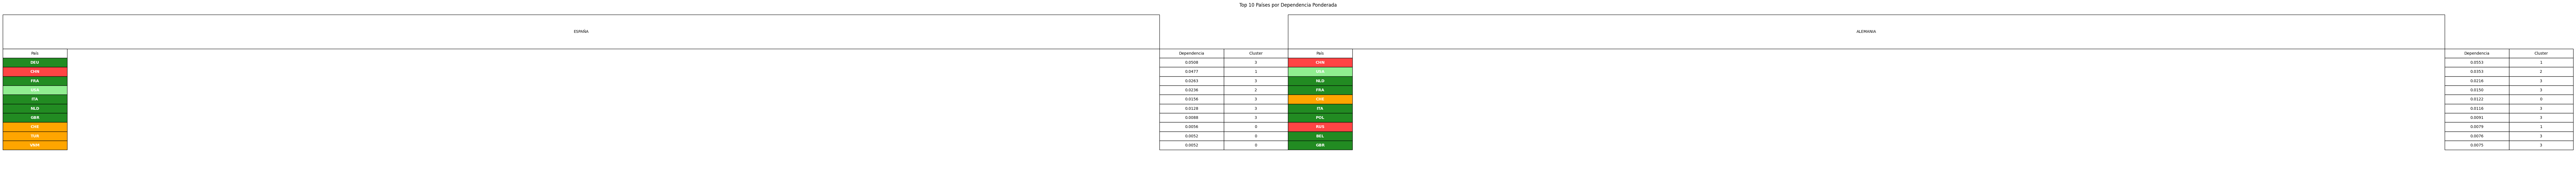

In [48]:
def crear_tabla_comparativa(weighted_deps, cluster_data):
   cluster_colors = {
       1: '#FF4444',  # Rojo
       0: '#FFA500',  # Naranja
       2: '#90EE90',  # Verde claro
       3: '#228B22',  # Verde
       4: '#FFD700'   # Amarillo
   }
   
   # Preparar datos para ESP y DEU
   esp_data = weighted_deps[weighted_deps['dependent_country'] == 'ESP'].merge(
       cluster_data[['iso_d', 'cluster']], 
       left_on='supplier_country', 
       right_on='iso_d'
   )
   deu_data = weighted_deps[weighted_deps['dependent_country'] == 'DEU'].merge(
       cluster_data[['iso_d', 'cluster']], 
       left_on='supplier_country', 
       right_on='iso_d'
   )
   
   fig, ax = plt.subplots(figsize=(12, 8))
   ax.axis('off')
   
   # Preparar datos para la tabla
   table_data = []
   for i in range(10):
       row = [
           esp_data.iloc[i]['supplier_country'],
           f"{esp_data.iloc[i]['weighted_contribution']:.4f}",
           esp_data.iloc[i]['cluster'],
           deu_data.iloc[i]['supplier_country'],
           f"{deu_data.iloc[i]['weighted_contribution']:.4f}",
           deu_data.iloc[i]['cluster']
       ]
       table_data.append(row)
   
   tabla = ax.table(
       cellText=table_data,
       colLabels=['País', 'Dependencia', 'Cluster', 'País', 'Dependencia', 'Cluster'],
       loc='center',
       cellLoc='center'
   )
   
   # Headers para España y Alemania
   tabla.add_cell(-2, 0, width=3, height=0.1, text='ESPAÑA', loc='center')
   tabla.add_cell(-2, 3, width=3, height=0.1, text='ALEMANIA', loc='center')
   
   tabla.auto_set_font_size(False)
   tabla.set_fontsize(10)
   tabla.scale(1.5, 2)
   
   # Colorear celdas según cluster
   for idx, row in enumerate(table_data):
       # España
       tabla._cells[(idx+1, 0)].set_facecolor(cluster_colors[row[2]])
       tabla._cells[(idx+1, 0)].set_text_props(color='white', weight='bold')
       # Alemania
       tabla._cells[(idx+1, 3)].set_facecolor(cluster_colors[row[5]])
       tabla._cells[(idx+1, 3)].set_text_props(color='white', weight='bold')
   
   plt.title('Top 10 Países por Dependencia Ponderada', pad=20)
   plt.show()

crear_tabla_comparativa(result, clustering_data)

Total de filas para EE.UU.: 2916
Calculando valor comercial por país...
Top 20 países por valor comercial: CHN, MEX, CAN, JPN, DEU...
Calculando dependencias ponderadas...

Top 20 países por dependencia ponderada:
1. CHN: Dependencia: 0.478, Directa: 0.304 (63.6%), Indirecta: 0.174 (36.4%), Valor comercial: 472K USD
11. VNM: Dependencia: 0.257, Directa: 0.105 (40.8%), Indirecta: 0.152 (59.2%), Valor comercial: 66K USD
14. CHE: Dependencia: 0.169, Directa: 0.109 (64.4%), Indirecta: 0.060 (35.6%), Valor comercial: 43K USD
15. MYS: Dependencia: 0.167, Directa: 0.136 (81.0%), Indirecta: 0.032 (19.0%), Valor comercial: 39K USD
7. IRL: Dependencia: 0.157, Directa: 0.135 (85.8%), Indirecta: 0.022 (14.2%), Valor comercial: 91K USD
2. MEX: Dependencia: 0.140, Directa: 0.134 (95.5%), Indirecta: 0.006 (4.5%), Valor comercial: 374K USD
4. JPN: Dependencia: 0.130, Directa: 0.082 (63.1%), Indirecta: 0.048 (36.9%), Valor comercial: 170K USD
13. TWN: Dependencia: 0.129, Directa: 0.046 (35.8%), Indirec

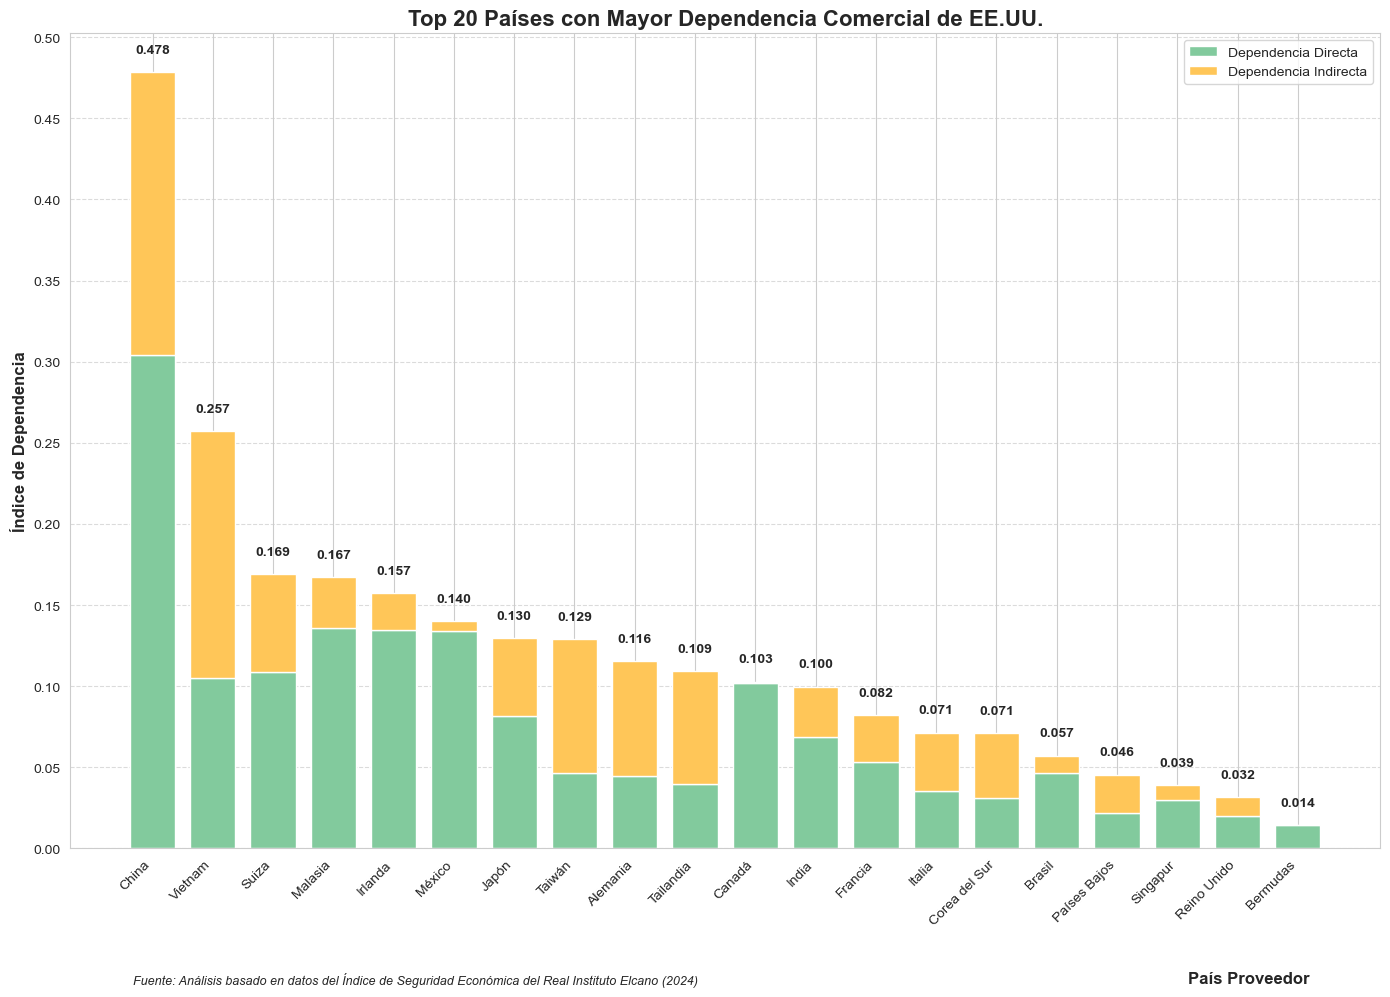


Top 5 industrias con mayor dependencia de China:
240424. Games and toys: Dependencia: 0.983, Directa: 0.845, Indirecta: 0.137, Valor comercial: 18K USD
56900. Bicycles and invalid carriages: Dependencia: 0.873, Directa: 0.473, Indirecta: 0.399, Valor comercial: 1K USD
380039. Office accounting and computing machinery: Dependencia: 0.844, Directa: 0.463, Indirecta: 0.381, Valor comercial: 54K USD
653571. TV and radio receivers and associated goods: Dependencia: 0.774, Directa: 0.465, Indirecta: 0.309, Valor comercial: 21K USD
657620. TV/radio transmitters; line comm. apparatus: Dependencia: 0.766, Directa: 0.526, Indirecta: 0.240, Valor comercial: 62K USD


In [7]:

def analyze_us_dependencies():
    """
    Analiza las dependencias comerciales de EE.UU. a partir de un archivo CSV.
    
    Args:
        file_path: Ruta al archivo CSV de dependencias comerciales
        
    Returns:
        DataFrame con las dependencias ponderadas ordenadas
    """
    # Cargar los datos
    # 
    df = df_limpio.copy()
    
    # Filtrar datos para EE.UU. como país dependiente
    us_data = df[df['dependent_country'] == 'USA'].copy()
    print(f"Total de filas para EE.UU.: {len(us_data)}")
    
    # 1. Calcular el valor comercial total por país proveedor
    print("Calculando valor comercial por país...")
    trade_value_by_country = us_data.groupby('supplier_country')['trade_value'].sum().reset_index()
    trade_value_by_country = trade_value_by_country.sort_values('trade_value', ascending=False)
    
    # Obtener los 20 principales países por valor comercial
    top20_countries = trade_value_by_country.head(20)['supplier_country'].tolist()
    print(f"Top 20 países por valor comercial: {', '.join(top20_countries[:5])}...")
    
    # 2. Calcular dependencia media ponderada para cada uno de los top 20 países
    print("Calculando dependencias ponderadas...")
    dependency_results = []
    
    for country in top20_countries:
        # Filtrar datos para este país proveedor
        country_data = us_data[us_data['supplier_country'] == country].copy()
        
        # Filtrar filas con valores válidos
        valid_rows = country_data.dropna(subset=['dependency_value', 'trade_value'])
        valid_rows = valid_rows[valid_rows['trade_value'] > 0]
        
        if len(valid_rows) == 0:
            dependency_results.append({
                'country': country,
                'weighted_dependency': 0,
                'weighted_direct_dependency': 0,
                'weighted_indirect_dependency': 0,
                'total_trade_value': trade_value_by_country[trade_value_by_country['supplier_country'] == country]['trade_value'].values[0]
            })
            continue
        
        # Calcular pesos basados en trade_value
        total_trade_value = valid_rows['trade_value'].sum()
        valid_rows['weight'] = valid_rows['trade_value'] / total_trade_value
        
        # Calcular dependencia ponderada
        weighted_dependency = (valid_rows['dependency_value'] * valid_rows['weight']).sum()
        weighted_direct = (valid_rows['direct_dependency'] * valid_rows['weight']).sum()
        weighted_indirect = (valid_rows['indirect_dependency'] * valid_rows['weight']).sum()
        
        dependency_results.append({
            'country': country,
            'weighted_dependency': weighted_dependency,
            'weighted_direct_dependency': weighted_direct,
            'weighted_indirect_dependency': weighted_indirect,
            'total_trade_value': trade_value_by_country[trade_value_by_country['supplier_country'] == country]['trade_value'].values[0]
        })
    
    # Convertir a DataFrame y ordenar por dependencia ponderada
    dependency_df = pd.DataFrame(dependency_results)
    dependency_df = dependency_df.sort_values('weighted_dependency', ascending=False)
    
    return dependency_df

def plot_dependencies(dependency_df):
    """
    Crea un gráfico de barras apiladas para visualizar las dependencias.
    
    Args:
        dependency_df: DataFrame con las dependencias calculadas
    """
    plt.figure(figsize=(14, 10))
    
    # Preparar datos para el gráfico
    countries = dependency_df['country'].tolist()
    direct_deps = dependency_df['weighted_direct_dependency'].tolist()
    indirect_deps = dependency_df['weighted_indirect_dependency'].tolist()
    
    # Crear diccionario para mapear códigos de país a nombres completos
    country_names = {
        "CHN": "China", "VNM": "Vietnam", "CHE": "Suiza", "MYS": "Malasia",
        "IRL": "Irlanda", "MEX": "México", "JPN": "Japón", "TWN": "Taiwán",
        "DEU": "Alemania", "THA": "Tailandia", "CAN": "Canadá", "IND": "India",
        "FRA": "Francia", "ITA": "Italia", "KOR": "Corea del Sur", "BRA": "Brasil",
        "NLD": "Países Bajos", "SGP": "Singapur", "GBR": "Reino Unido", "BMU": "Bermudas"
    }
    
    # Mapear códigos a nombres completos (si están en el diccionario)
    country_labels = [country_names.get(c, c) for c in countries]
    
    # Crear gráfico
    bar_width = 0.75
    x = np.arange(len(countries))
    
    # Establecer estilo
    sns.set_style('whitegrid')
    plt.rcParams['font.sans-serif'] = ['Arial']
    
    # Crear barras apiladas
    p1 = plt.bar(x, direct_deps, bar_width, label='Dependencia Directa', color='#82ca9d')
    p2 = plt.bar(x, indirect_deps, bar_width, bottom=direct_deps, label='Dependencia Indirecta', color='#ffc658')
    
    # Añadir etiquetas de valores para la dependencia total
    for i, country in enumerate(countries):
        total_dep = dependency_df.loc[dependency_df['country'] == country, 'weighted_dependency'].values[0]
        plt.text(x=i, y=total_dep + 0.01, s=f"{total_dep:.3f}", ha='center', va='bottom', fontweight='bold')
    
    # Configurar ejes y etiquetas
    plt.ylabel('Índice de Dependencia', fontsize=12, fontweight='bold')
    plt.title('Top 20 Países con Mayor Dependencia Comercial de EE.UU.', fontsize=16, fontweight='bold')
    plt.xticks(x, country_labels, rotation=45, ha='right')
    plt.yticks(np.arange(0, 0.55, 0.05))
    
    # Añadir etiqueta del eje X a la derecha
    ax = plt.gca()
    ax.set_xlabel('País Proveedor', fontsize=12, fontweight='bold')
    ax.xaxis.set_label_coords(0.9, -0.15)  # Posición (x, y) de la etiqueta: x=0.9 (derecha), y=-0.15 (debajo del eje)
    
    # Añadir leyenda
    plt.legend(loc='upper right')
    
    # Añadir cuadrícula horizontal
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Ajustar layout
    plt.tight_layout()
    
    # Añadir anotación con fuente
    plt.figtext(0.3, 0.01, "Fuente: Análisis basado en datos del Índice de Seguridad Económica del Real Instituto Elcano (2024)",
               ha="center", fontsize=9, style='italic')
    
    # Guardar y mostrar
    plt.savefig('us_dependencies.png', dpi=300, bbox_inches='tight')
    print("Gráfico guardado como 'us_dependencies.png'")
    plt.show()
    
    return

def main():
    """Función principal para el análisis de dependencias."""
    # Ruta al archivo de datos
    # Realizar análisis
    dependency_df = analyze_us_dependencies()
    
    # Mostrar resultados
    print("\nTop 20 países por dependencia ponderada:")
    for i, row in dependency_df.iterrows():
        print(f"{i+1}. {row['country']}: Dependencia: {row['weighted_dependency']:.3f}, " +
              f"Directa: {row['weighted_direct_dependency']:.3f} " +
              f"({row['weighted_direct_dependency']/row['weighted_dependency']*100:.1f}%), " +
              f"Indirecta: {row['weighted_indirect_dependency']:.3f} " +
              f"({row['weighted_indirect_dependency']/row['weighted_dependency']*100:.1f}%), " +
              f"Valor comercial: {row['total_trade_value']/1000:.0f}K USD")
    
    # Crear visualización
    plot_dependencies(dependency_df)
    
    # Analizar y mostrar las industrias con mayor dependencia de China
    analyze_china_industries()
    
    return dependency_df

def analyze_china_industries():
    """Analiza las industrias con mayor dependencia de China."""
    # Cargar los datos
    df = df_limpio.copy()
    
    # Filtrar datos para EE.UU. como país dependiente y China como proveedor
    china_data = df[(df['dependent_country'] == 'USA') & (df['supplier_country'] == 'CHN')].copy()
    
    # Filtrar filas con valores válidos
    valid_rows = china_data.dropna(subset=['dependency_value', 'trade_value'])
    valid_rows = valid_rows[valid_rows['trade_value'] > 0]
    
    # Ordenar por dependencia
    top_industries = valid_rows.sort_values('dependency_value', ascending=False).head(5)
    
    print("\nTop 5 industrias con mayor dependencia de China:")
    for i, row in top_industries.iterrows():
        print(f"{i+1}. {row['industry']}: Dependencia: {row['dependency_value']:.3f}, " +
              f"Directa: {row['direct_dependency']:.3f}, Indirecta: {row['indirect_dependency']:.3f}, " +
              f"Valor comercial: {row['trade_value']/1000:.0f}K USD")
    
    return top_industries

if __name__ == "__main__":
    dependency_df = main()

Total de filas para relaciones EE.UU.-China: 121

Top sectores por dependencia de China:
240424. Games and toys: Dependencia: 0.983, Directa: 0.845 (86.0%), Indirecta: 0.137 (14.0%), Valor comercial: 17.8K USD
56900. Bicycles and invalid carriages: Dependencia: 0.873, Directa: 0.473 (54.2%), Indirecta: 0.399 (45.8%), Valor comercial: 1.2K USD
380039. Office accounting and computing machinery: Dependencia: 0.844, Directa: 0.463 (54.8%), Indirecta: 0.381 (45.2%), Valor comercial: 54.1K USD
653571. TV and radio receivers and associated goods: Dependencia: 0.774, Directa: 0.465 (60.1%), Indirecta: 0.309 (39.9%), Valor comercial: 20.5K USD
657620. TV/radio transmitters; line comm. apparatus: Dependencia: 0.766, Directa: 0.526 (68.7%), Indirecta: 0.240 (31.3%), Valor comercial: 62.1K USD
213190. Footwear: Dependencia: 0.757, Directa: 0.499 (65.9%), Indirecta: 0.258 (34.1%), Valor comercial: 14.0K USD
329442. Made-up textile articles except apparel: Dependencia: 0.748, Directa: 0.551 (73.6%),

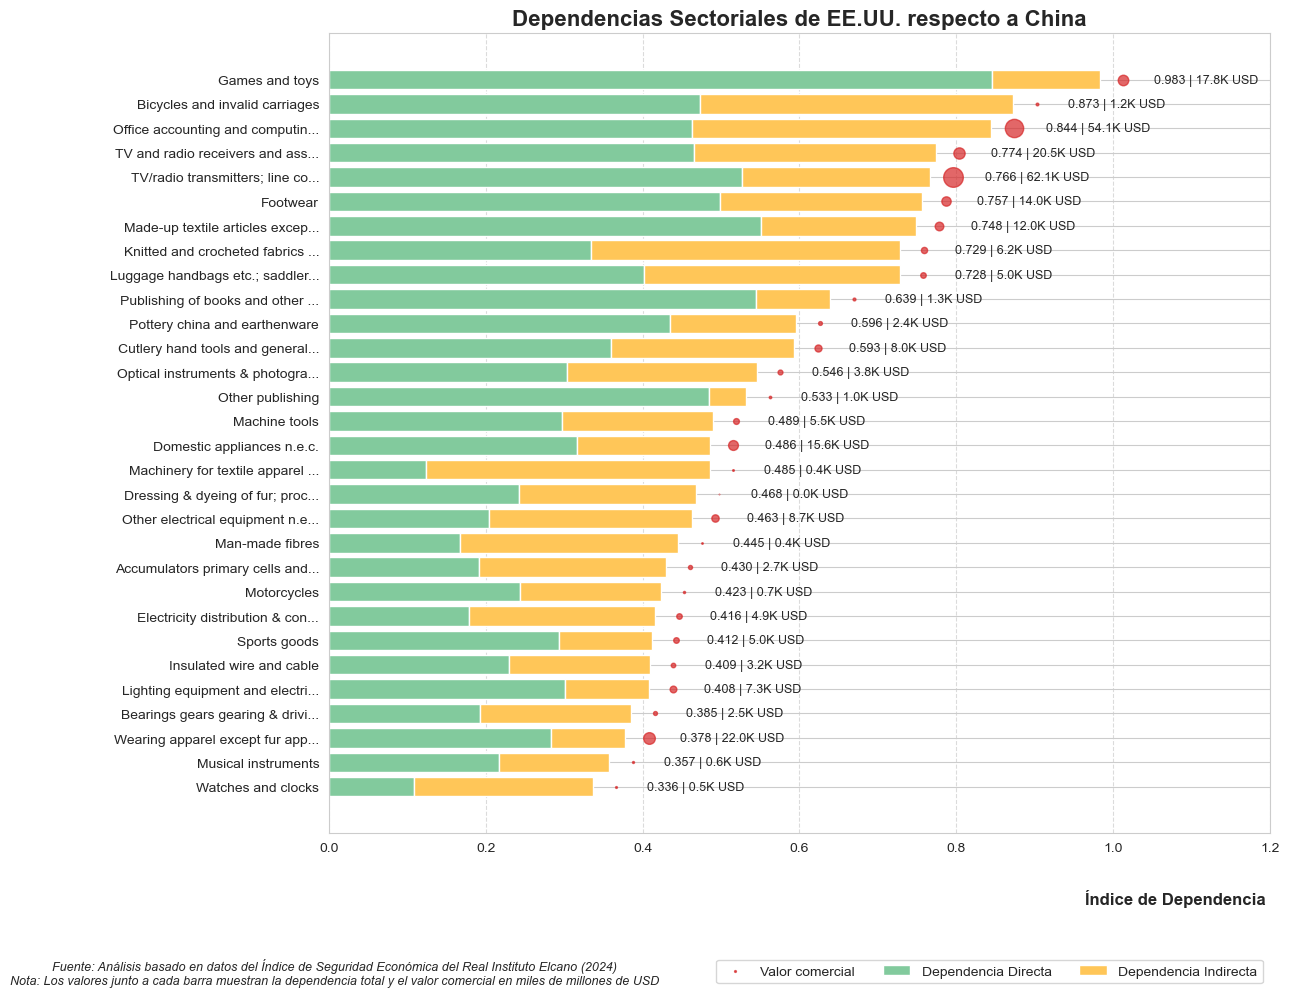

In [10]:
def analyze_china_sectoral_dependencies(num_sectors=30):
    """
    Analiza las dependencias sectoriales de EE.UU. respecto a China.
    
    Args:
        file_path: Ruta al archivo CSV de dependencias comerciales
        num_sectors: Número de sectores a mostrar en el gráfico
        
    Returns:
        DataFrame con los sectores de mayor dependencia
    """
    # Cargar los datos
    df = df_limpio.copy()
    
    # Filtrar datos para EE.UU. como país dependiente y China como proveedor
    us_china_data = df[(df['dependent_country'] == 'USA') & 
                        (df['supplier_country'] == 'CHN')].copy()
    
    print(f"Total de filas para relaciones EE.UU.-China: {len(us_china_data)}")
    
    # Filtrar registros válidos y con valor comercial positivo
    valid_data = us_china_data.dropna(subset=['dependency_value', 'trade_value', 'direct_dependency', 'indirect_dependency'])
    valid_data = valid_data[valid_data['trade_value'] > 0]
    
    # Ordenar por dependencia total
    sorted_data = valid_data.sort_values('dependency_value', ascending=False)
    
    # Obtener los N sectores con mayor dependencia
    top_sectors = sorted_data.head(num_sectors).copy()
    
    # Abreviar nombres de industrias demasiado largos
    top_sectors['short_industry'] = top_sectors['industry'].apply(
        lambda x: x[:30] + '...' if len(x) > 30 else x
    )
    
    # Crear columna con el porcentaje directo e indirecto
    total_dep = top_sectors['dependency_value']
    top_sectors['direct_pct'] = top_sectors['direct_dependency'] / total_dep * 100
    top_sectors['indirect_pct'] = top_sectors['indirect_dependency'] / total_dep * 100
    
    return top_sectors

def plot_china_sectoral_dependencies(sectors_df):
    """
    Crea un gráfico de barras horizontales para visualizar las dependencias sectoriales.
    
    Args:
        sectors_df: DataFrame con los sectores de mayor dependencia
    """
    # Preparar datos para el gráfico
    industries = sectors_df['short_industry'].tolist()
    direct_deps = sectors_df['direct_dependency'].tolist()
    indirect_deps = sectors_df['indirect_dependency'].tolist()
    trade_values = sectors_df['trade_value'].tolist()
    total_deps = sectors_df['dependency_value'].tolist()
    
    # Ordenar desde el valor más alto al más bajo (para visualización)
    indices = np.argsort(total_deps)
    industries = [industries[i] for i in indices]
    direct_deps = [direct_deps[i] for i in indices]
    indirect_deps = [indirect_deps[i] for i in indices]
    trade_values = [trade_values[i] for i in indices]
    total_deps = [total_deps[i] for i in indices]
    
    # Configurar el gráfico
    plt.figure(figsize=(12, 10))
    
    # Establecer estilo
    sns.set_style('whitegrid')
    plt.rcParams['font.sans-serif'] = ['Arial']
    
    # Crear gráfico de barras horizontales apiladas
    y_pos = np.arange(len(industries))
    
    # Barras apiladas
    p1 = plt.barh(y_pos, direct_deps, color='#82ca9d', label='Dependencia Directa')
    p2 = plt.barh(y_pos, indirect_deps, left=direct_deps, color='#ffc658', label='Dependencia Indirecta')
    
    # Añadir valor comercial como tamaño de puntos
    max_trade = max(trade_values)
    normalized_trade = [t/max_trade * 200 for t in trade_values]  # Normalizar para tamaño visual
    
    # Añadir puntos que representan el valor comercial
    for i, (dep, trade, norm_trade) in enumerate(zip(total_deps, trade_values, normalized_trade)):
        plt.scatter(dep + 0.03, i, s=norm_trade, color='#d62728', alpha=0.7, 
                   label='Valor comercial' if i == 0 else "")
    
    # Añadir etiquetas con el valor de dependencia y comercial
    for i, (dep, trade) in enumerate(zip(total_deps, trade_values)):
        plt.text(dep + 0.07, i, f"{dep:.3f} | {trade/1000:.1f}K USD", 
                 va='center', ha='left', fontsize=9)
    
    # Configurar ejes y etiquetas
    plt.yticks(y_pos, industries)
    plt.xlabel('Índice de Dependencia', fontsize=12, fontweight='bold')
    
    # Posicionar etiqueta del eje X
    ax = plt.gca()
    ax.xaxis.set_label_coords(0.9, -0.07)
    
    plt.title('Dependencias Sectoriales de EE.UU. respecto a China', fontsize=16, fontweight='bold')
    
    # Ajustar límites del eje X para dar espacio a las anotaciones
    plt.xlim(0, 1.2)
    
    # Añadir leyenda
    plt.legend(loc='upper right', bbox_to_anchor=(1, -0.15), ncol=3)
    
    # Ajustar layout
    plt.tight_layout()
    
    # Añadir cuadrícula vertical
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    
    # Añadir anotación con fuente y explicación
    plt.figtext(0.2, 0.01, 
                "Fuente: Análisis basado en datos del Índice de Seguridad Económica del Real Instituto Elcano (2024)\n"
                "Nota: Los valores junto a cada barra muestran la dependencia total y el valor comercial en miles de millones de USD",
                ha="center", fontsize=9, style='italic')
    
    # Guardar y mostrar
    plt.savefig('us_china_sectoral_dependencies.png', dpi=300, bbox_inches='tight')
    print("Gráfico guardado como 'us_china_sectoral_dependencies.png'")
    plt.show()
    
    return

def main():
    """Función principal para el análisis de dependencias sectoriales."""
    
    
    # Realizar análisis de los 15 sectores principales
    sectors_df = analyze_china_sectoral_dependencies(num_sectors=30)
    
    # Mostrar resultados
    print("\nTop sectores por dependencia de China:")
    for i, row in sectors_df.sort_values('dependency_value', ascending=False).iterrows():
        print(f"{i+1}. {row['industry']}: Dependencia: {row['dependency_value']:.3f}, " +
              f"Directa: {row['direct_dependency']:.3f} ({row['direct_pct']:.1f}%), " +
              f"Indirecta: {row['indirect_dependency']:.3f} ({row['indirect_pct']:.1f}%), " +
              f"Valor comercial: {row['trade_value']/1000:.1f}K USD")
    
    # Crear visualización
    plot_china_sectoral_dependencies(sectors_df)
    
    return sectors_df

if __name__ == "__main__":
    sectors_df = main()